In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [129]:
# build the dataset

block_size = 3 # context length: how many characters do we tak eto predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [25]:
 X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [306]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we tak eto predict the next one?
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
C = torch.randn((27, 2))

In [27]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [30]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [72]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [73]:
h

tensor([[ 0.9997, -0.9986, -0.5833,  ..., -0.9999,  1.0000, -1.0000],
        [ 1.0000, -0.9980, -0.9396,  ..., -0.9974,  1.0000, -0.8089],
        [ 0.9977, -0.9988, -0.9137,  ..., -0.9998,  1.0000, -0.9847],
        ...,
        [-0.8424,  0.8577,  0.0553,  ...,  0.9457, -0.9644,  0.9995],
        [-0.9996,  0.9687, -0.7842,  ...,  0.9948, -0.9962,  0.7122],
        [ 0.9950,  0.3854,  0.0089,  ..., -0.1829, -0.9347,  0.5928]])

In [74]:
h.shape

torch.Size([32, 100])

In [75]:
b1.shape

torch.Size([100])

In [76]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [77]:
logits = h @ W2 + b2

In [78]:
logits.shape

torch.Size([32, 27])

In [79]:
counts = logits.exp()

In [80]:
prob = counts / counts.sum(1, keepdims=True)

In [81]:
prob.shape

torch.Size([32, 27])

In [89]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(12.6181)

In [90]:
# -------------------------- #

In [307]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [346]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [347]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [348]:
for p in parameters:
    p.requires_grad = True

In [349]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [360]:
lri = []
lossi = []
stepi = []


In [361]:

for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    # lri.append(lre[i])
    lossi.append(loss.log10().item())


print(loss.item())

1.8626960515975952


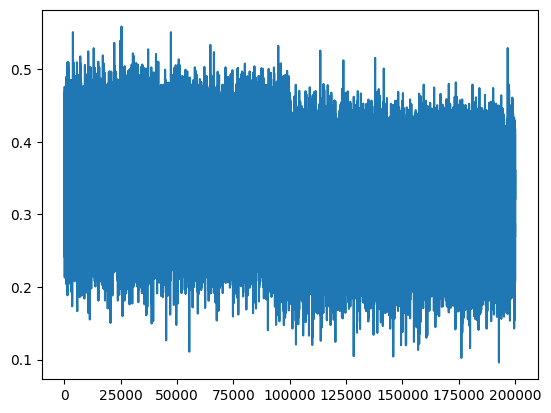

In [362]:
plt.plot(stepi, lossi)

In [363]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()


2.1452510356903076

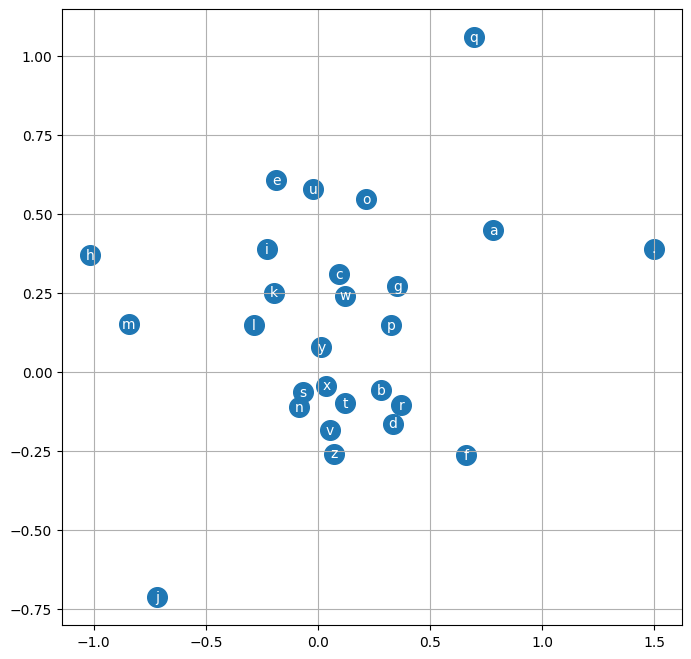

In [358]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [366]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
            
    print(''.join(out))

mora.
mayah.
see.
mad.
rylla.
emmadiejararge.
zeredieliigh.
parelle.
elisana.
artelle.
malaia.
noshuborgianaies.
kindretlynn.
noer.
fourten.
dariyah.
faeh.
yumajahston.
mahil.
salynn.
